In [55]:
import numpy as np
import os
from skimage.measure import block_reduce
from scipy.misc import imread
import cPickle as pkl
import scipy.signal
import numpy.fft as fft
import sys
import optparse
from libtiff import TIFF
from PIL import Image
import re
import itertools
from scipy import ndimage

import math
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.cm as cm
import pandas as pd

%matplotlib inline

def  cart2pol(x,y, units='deg'):
    """Convert from cartesian to polar coordinates

    :usage:

        theta, radius = pol2cart(x, y, units='deg')

    units refers to the units (rad or deg) for theta that should be returned
    """
    radius= np.hypot(x,y)
    theta= np.arctan2(y,x)
    if units in ['deg', 'degs']:
        theta=theta*180/np.pi
    return theta, radius


def pol2cart(theta, radius, units='deg'):
    """Convert from polar to cartesian coordinates

    usage::

        x,y = pol2cart(theta, radius, units='deg')

    """
    if units in ['deg', 'degs']:
        theta = theta*np.pi/180.0
    xx = radius*np.cos(theta)
    yy = radius*np.sin(theta)

    return xx,yy

In [56]:

threshold = 0.5 #float(options.threshold)

# rev = False #options.rev # CW IS REVERSE

# print "REV STATE: ", rev
get_absolute = True #False #options.get_absolute

key = 'stimulus' #options.key
im_format = '.tif' # '.'+options.im_format
headless = False #options.headless
reduce_factor = (1, 1) #(int(options.reduce_val), int(options.reduce_val))
if reduce_factor[0] > 0:
	reduceit=1
else:
	reduceit=0
gsigma = 0 #int(options.gauss_kernel)
if headless:
	mpl.use('Agg')
	

In [57]:
# outdir = '/media/juliana/TOSHIBA EXT/widefield/CE004/20160203/awake_circle_0013_REV/structs'
outdir = '/media/nas/volume1/widefield/data/CE004/20160203/awake_circle_0013_REV/structs'
# outdir = '/media/nas/volume1/widefield/data/CE004/20160203/awake_circle_0013/structs'
# outdir = '/media/nas/volume1/widefield/data/JR001B/20160507/red_loc2_circle_CW/structs'

CW = True #options.rev # CW IS REVERSE
if CW:
    rev=True
else:
    rev=False
    
print "REV STATE: ", CW

if rev=='False' and '_CW' in outdir:
    print "Fixing REV status [CW detected in fn]..."
    CW = True

rundir = os.path.split(outdir)[0]
sessiondir = os.path.split(rundir)[0]

print "REV STATE: ", CW


REV STATE:  True
REV STATE:  True


/media/nas/volume1/widefield/data/CE004/20160203
['surface_20160203.tif']
.tif


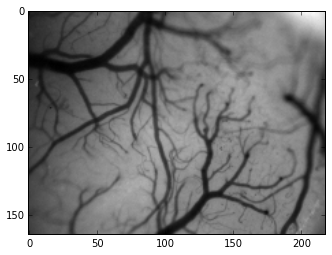

In [58]:
#################################################################################
# GET BLOOD VESSEL IMAGE:
#################################################################################
folders = os.listdir(rundir)
figpath = [f for f in folders if f == 'figures']
print sessiondir

if figpath:
    figdir = figpath[0]
    tmp_ims = os.listdir(os.path.join(sessiondir, figdir))
    surface_words = ['surface', 'GREEN', 'green', 'Surface']
    ims = [i for i in tmp_ims if any([word in i for word in surface_words])]
    print ims
    impath = os.path.join(sessiondir, figdir, ims[0])
    # image = Image.open(impath) #.convert('L')
    # imarray = np.asarray(image)
    print os.path.splitext(impath)[1]
    if os.path.splitext(impath)[1] == '.tif':
        tiff = TIFF.open(impath, mode='r')
        surface = tiff.read_image().astype('float')
        tiff.close()
        plt.imshow(surface)
    else:
        image = Image.open(impath) #.convert('L')
        surface = np.asarray(image)


else: # NO BLOOD VESSEL IMAGE...
    surface = np.zeros([200,300])

if reduceit:
    surface = block_reduce(surface, reduce_factor, func=np.mean)

plt.imshow(surface, cmap='gray')

In [59]:

#################################################################################
# GET DATA STRUCT FILES:
#################################################################################
append = 'detrend'

files = os.listdir(outdir)
files = [f for f in files if os.path.splitext(f)[1] == '.pkl']
dstructs = [f for f in files if 'Target_fft' in f and str(reduce_factor) and key in f and append in f]

print dstructs
print outdir
D = dict()
for f in dstructs:
	outfile = os.path.join(outdir, f)
	with open(outfile,'rb') as fp:
		D[f] = pkl.load(fp)
print D.keys()

cw_key = D.keys()[0]

astructs = [f for f in files if 'Amplitudes' in f]
A = dict()
for f in astructs:
	outfile = os.path.join(outdir, f)
	with open(outfile,'rb') as fp:
		A[f] = pkl.load(fp)
print A.keys()

a_key = A.keys()[0]

['Target_fft_stimulus_(1, 1)_detrendfirst.pkl']
/media/nas/volume1/widefield/data/CE004/20160203/awake_circle_0013_REV/structs
['Target_fft_stimulus_(1, 1)_detrendfirst.pkl']
['Amplitudes_stimulus_(1, 1)_ratio.pkl']


In [61]:
curr_key = cw_key
print "D keys:", D[curr_key].keys()

print "A keys:", A[a_key].keys()

 D keys: ['phase_map', 'DC', 'dynrange', 'DC_mag', 'DC_phase', 'mag_map', 'target_freq', 'binsize', 'degrees', 'fps', 'mean_intensity', 'DC_freq', 'direction', 'shift_degrees', 'ft', 'DC_bin', 'strt_idxs', 'reduce_factor', 'target_bin', 'nframes_per_cycle', 'positions', 'freqs']
A keys: ['ft', 'ratio_map', 'target_freq', 'freqs', 'binsize', 'dB_map', 'fps', 'reduce_factor', 'nframes', 'target_bin']


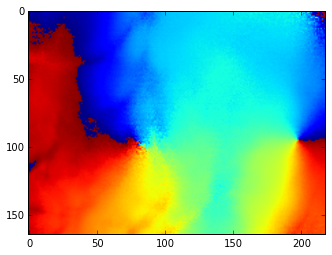

In [62]:
# Get the stuffs.

ratio_map = A[a_key]['ratio_map']
phase_map = np.angle(D[curr_key]['ft'])

plt.imshow(phase_map)


1.87428278683e-12
2.70723189402e-07


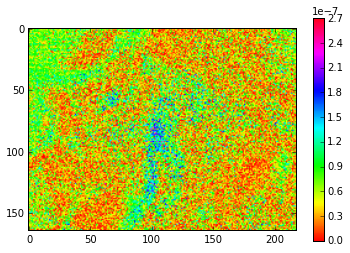

In [74]:
# NORMALIZE to HSV:

Ny = len(D[curr_key]['freqs'])/2.

old_min = -math.pi #phase_map.min()
old_max = math.pi #phase_map.max()
new_min = 0
new_max = 1
normed_phase_map = np.zeros(phase_map.shape)
for x in range(phase_map.shape[0]):
    for y in range(phase_map.shape[1]):
        old_val = phase_map[x, y]
        normed_phase_map[x, y] = (((old_val - old_min) * (new_max - new_min)) / (old_max - old_min)) + new_min

# old_min = mag_map.min()
# old_max = mag_map.max()
# new_min = 0
# new_max = 1
# normed_mag_map = np.zeros(mag_map.shape)
# for x in range(mag_map.shape[0]):
#     for y in range(mag_map.shape[1]):
#         old_val = mag_map[x, y]
#         normed_mag_map[x, y] = (((old_val - old_min) * (new_max - new_min)) / (old_max - old_min)) + new_min

hue = normed_phase_map
sat = np.ones(hue.shape)
val = ratio_map/Ny #normed_mag_map

HSV = np.ones(val.shape + (3,))
HSV[...,0] = hue
HSV[...,2] = sat * 1
HSV[...,1] = val

plt.imshow(val, cmap='hsv')
plt.colorbar()

print val.min()
print val.max()


In [75]:
# import copy
# cutoff = .3*max(normed_mag_map.ravel())
# print "Cutoff at: ", cutoff
# # thresh_val = copy.deepcopy(val)
# nons = []
# for x in range(val.shape[0]):
#     for y in range(val.shape[1]):
# #         print thresh_val[x, y]
#         if val[x, y] < cutoff:
#             nons.append([x,y])
# print len(nons)

# HSV TO RGB:

import colorsys
convmap = np.empty(HSV.shape)

for i in range(HSV.shape[0]):
    for j in range(HSV.shape[1]):

            convmap[i, j, :] = colorsys.hsv_to_rgb(HSV[i,j,:][0],HSV[i,j,:][1],HSV[i,j,:][2])


0.998750612481 1.0


<matplotlib.colorbar.Colorbar instance at 0x7faf18bb04d0>

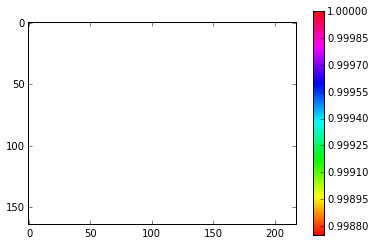

In [73]:
# MASK:
print convmap.min(), convmap.max()
# alpha_channel = np.ones(convmap[:,:,1].shape)
# print alpha_channel.shape
# for i in nons:
#     alpha_channel[i[0], i[1]] = 1

# composite = np.empty((alpha_channel.shape[0], alpha_channel.shape[1], 4))
# composite[:,:,0:3] = convmap[:,:,:]

# composite[:,:,3] = alpha_channel


plt.imshow(surface, 'gray')
plt.imshow(convmap, 'hsv') #, vmin=0, vmax=1)
# plt.axis('off')
plt.colorbar()

(0.0, 6.2831853071795862, -1.0, 1.0)

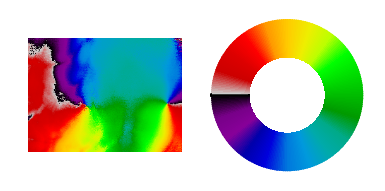

In [27]:
fig = plt.figure()

fig.add_subplot(1,2,1)
plt.imshow(np.angle(D[cw_key]['ft']), cmap='spectral')
plt.axis('off')

ax = fig.add_subplot(1,2,2, projection='polar')
ax.set_theta_zero_location('W') # W puts 0 on RIGHT side...

if CW:
    ax._direction = 2*np.pi # object moves toward bottom first (CW)
else:
    ax._direction = -2*np.pi # objecct moves toward top first (CCW)

norm = mpl.colors.Normalize(vmax=1*np.pi, vmin=-1*np.pi)
#norm = mpl.colors.Normalize(vmax=2*np.pi, vmin=0)
cb = mpl.colorbar.ColorbarBase(ax, cmap=cm.get_cmap('spectral'),
                                norm=norm, orientation='horizontal')
# cb.ax.invert_xaxis()
# cb.outline.set_visible(False)
# ax.set_axis_off()
ax.set_rlim([-1, 1])
ax.axis('off')

(164, 218)
/media/nas/volume1/widefield/data/CE004/20160203/awake_circle_0013_REV/structs/CW_phase_overlay_withkey_threshold0.30.jpg


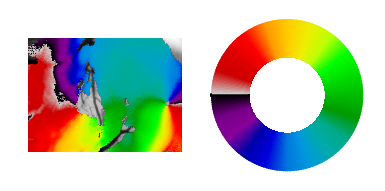

In [28]:
use_mean_intensity = 0 # set to 1 if want to threshold with mean intensity values instead of magnitude
use_log = 1
threshold = 0.30
Ny = len(D[curr_key]['freqs'])/2.
mag_map = D[curr_key]['mag_map']/Ny
phase_map = D[curr_key]['phase_map']

#-----------------------------------------------------------------
# Overlaid Phase-map, thresholded
#-----------------------------------------------------------------

fig = plt.figure()

fig.add_subplot(1,2,1)
plt.imshow(surface,cmap=cm.Greys_r)
print surface.shape

if use_mean_intensity:
    mean_intensity = D[curr_key]['mean_intensity']
    [x, y] = np.where(mean_intensity >= threshold*mean_intensity.max())
    phase_mask = np.ones(mean_intensity.shape) * 100
    # phase_mask[x, y] = phase_map[x, y]
    phase_mask[x, y] = D[curr_key]['phase_map'][x, y]
    tit = 'Threshold, %.2f of mean intensity max' % (threshold)

else:
    if use_log:
        [x, y] = np.where(np.log(mag_map) >= threshold * np.log(mag_map.max()))
    else:
        [x, y] = np.where(mag_map >= threshold * mag_map.max())
    phase_mask = np.ones(mag_map.shape) * 100
    phase_mask[x, y] = phase_map[x, y]
    tit = 'Threshold, %.2f of log max magnitude' % (threshold)

[nullx, nully] = np.where(phase_mask == 100)
phase_mask[nullx, nully] = np.nan
phase_mask = np.ma.array(phase_mask)
plt.imshow(phase_mask, cmap='spectral', vmin=-1*math.pi, vmax=math.pi)
plt.axis('off')


#-----------------------------------------------------------------
# LEGEND
#-----------------------------------------------------------------

ax = fig.add_subplot(1,2,2, projection='polar')
ax.set_theta_zero_location('W') # W puts 0 on RIGHT side...

if CW:
    ax._direction = 2*np.pi # object moves toward bottom first (CW)
else:
    ax._direction = -2*np.pi # objecct moves toward top first (CCW)

norm = mpl.colors.Normalize(vmax=1*np.pi, vmin=-1*np.pi)
#norm = mpl.colors.Normalize(vmax=2*np.pi, vmin=0)
cb = mpl.colorbar.ColorbarBase(ax, cmap=cm.get_cmap('spectral'),
                                norm=norm, orientation='horizontal')
# cb.ax.invert_xaxis()
# cb.outline.set_visible(False)
# ax.set_axis_off()
ax.set_rlim([-1, 1])
ax.axis('off')

if CW:
    imname = 'CW_phase_overlay_withkey_threshold%.2f' % threshold
else:
    imname = 'CCW_phase_overlay_withkey_threshold%.2f' % threshold
impath = os.path.join(outdir, imname+'.eps')
plt.savefig(impath, format='svg', dpi=1200)

impath = os.path.join(outdir, imname+'.jpg')
plt.savefig(impath, format='jpg')


print impath

(164, 218)
Target_fft_stimulus_(1, 1)_detrendfirst.pkl
4615.0
/media/nas/volume1/widefield/data/CE004/20160203/awake_circle_0013_REV/structs/CW_magnitude_map_detrend.jpg


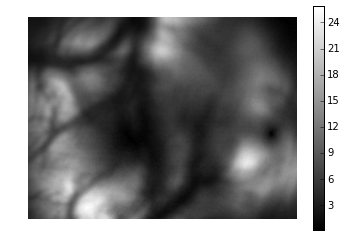

In [29]:
# PLOT:  magnitude map
ft = D[curr_key]['ft']
print ft.shape
print curr_key

mag_map = D[curr_key]['mag_map']

N = len(D[curr_key]['positions'])
Ny = N / 2.
print Ny

norm_mag_map = np.empty(mag_map.shape)
for x in range(mag_map.shape[0]):
    for y in range(mag_map.shape[1]):
        norm_mag_map[x, y] = 2 * mag_map[x, y] / Ny
        # Q:  is this diff, depending on whether take abs(full_ft_seq) vs. abs(HALF_seq)? if so, can't just div by 2 here
        # CHECK RAW on "stack"
        
# plt.imshow(norm_mag_map, cmap='gray')
plt.imshow(mag_map/Ny, cmap='gray')
plt.colorbar()
plt.axis('off')

if CW:
    imname = 'CW_magnitude_map_%s' % append
else:
    imname = 'CCW_magnitude_map_%s' % append
impath = os.path.join(outdir, imname+'.svg')
plt.savefig(impath, format='svg', dpi=1200)

impath = os.path.join(outdir, imname+'.jpg')
plt.savefig(impath, format='jpg')


print impath

In [229]:
# How does this compare to time-domain?

# imdir = '/media/nas/volume1/widefield/data/CE004/20160203/awake_circle_0013_REV/stimulus'
imdir = '/media/nas/volume1/widefield/data/CE004/20160203/awake_circle_0013/stimulus'

CW = False

files = os.listdir(imdir)
print len(files)
files = sorted([f for f in files if os.path.splitext(f)[1] == str(im_format)])
print len(files)

9231
9231


In [230]:
# Read in stack:
print imdir
tiff = TIFF.open(os.path.join(imdir, files[0]), mode='r')
sample = tiff.read_image().astype('float')
print "sample type: %s, range: %s" % (sample.dtype, str([sample.max(), sample.min()]))
print "sample shape: %s" % str(sample.shape)
tiff.close()

stack = np.empty((sample.shape[0], sample.shape[1], len(files)))

for i, f in enumerate(files):

    if i % 1000 == 0:
        print('%d images processed...' % i)
    tiff = TIFF.open(os.path.join(imdir, f), mode='r')
    im = tiff.read_image().astype('float')
    tiff.close()
    
    stack[:, :, i] = im


/media/nas/volume1/widefield/data/CE004/20160203/awake_circle_0013/stimulus
sample type: float64, range: [1474.0, 75.0]
sample shape: (164, 218)
0 images processed...
1000 images processed...
2000 images processed...
3000 images processed...
4000 images processed...
5000 images processed...
6000 images processed...
7000 images processed...
8000 images processed...
9000 images processed...


In [231]:
# GET cycle starts:
CW = False

positions = [re.findall("\[([^[\]]*)\]", f) for f in files]
plist = list(itertools.chain.from_iterable(positions))
pos = []
for i in plist:
    split_string = i.split(' ')
    split_num = [float(s) for s in split_string if s is not '']
    pos.append([split_num[0], split_num[1]])

degs = [cart2pol(p[0], p[1], units='deg') for p in pos]

degrees = [i[0] for i in degs]
shift_degrees = [i[0] for i in degs]
for x in range(len(shift_degrees)):
    if shift_degrees[x] < 0:
        shift_degrees[x] += 360.

if CW:
    find_cycs = list(itertools.chain.from_iterable(np.where(np.diff(shift_degrees) > 0)))
else:
    find_cycs = list(itertools.chain.from_iterable(np.where(np.diff(shift_degrees) < 0)))


print find_cycs
strt_idxs = [i + 1 for i in find_cycs]
strt_idxs.append(0)
strt_idxs.append(len(positions))
strt_idxs = sorted(strt_idxs)
nframes_per_cycle = [strt_idxs[i] - strt_idxs[i - 1] for i in range(1, len(strt_idxs))]
print nframes_per_cycle

[460, 922, 1383, 1845, 2306, 2768, 3230, 3691, 4153, 4614, 5076, 5537, 5999, 6460, 6922, 7384, 7845, 8307, 8768]
[461, 462, 461, 462, 461, 462, 462, 461, 462, 461, 462, 461, 462, 461, 462, 462, 461, 462, 461, 462]


In [232]:
# create separate copy of stack:
# del S/
import copy
S = copy.deepcopy(stack)


<matplotlib.colorbar.Colorbar instance at 0x7f0195e7a098>

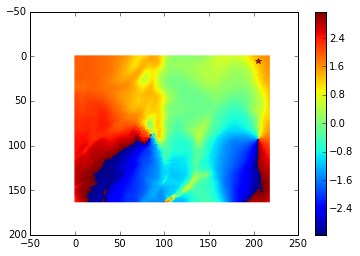

In [188]:

plt.imshow(D[curr_key]['phase_map'])

# x = 80
# y = 100
# plt.plot(x, y, 'w*')

# x = 60
# y = 130
# plt.plot(x, y, 'r*')

x=205
y=5
plt.plot(x, y, 'r*')

plt.colorbar()


In [134]:
print outdir
print D.keys(), curr_key

fig = plt.figure()
data = D[curr_key]['phase_map']

# ax.set_xticks(np.arange(data.shape[0])+0.5, minor=False)
# ax.set_yticks(np.arange(data.shape[1])+0.5, minor=False)

x = np.arange(data.shape[0])+0.5
y = np.arange(data.shape[1])+0.5
z = []
for i in range(data.shape[0]):
    z.append(data[i,:])

zflip = np.flipud(z)

from plotly.graph_objs import *

data = Data([
    Contour(
        z=zflip
    )
])
# plot_url = plot(data, filename='simple-contour')

import plotly.plotly as py
py.iplot(data)

/media/nas/volume1/widefield/data/CE004/20160203/awake_circle_0013/structs
['Target_fft_stimulus_(1, 1)_detrendfirst.pkl'] Target_fft_stimulus_(1, 1)_detrendfirst.pkl


/media/nas/volume1/widefield/data/CE004/20160203/awake_circle_0013/structs/mag_locs_CCW_pixel_x48_y200_detrend_MAP_small.jpg


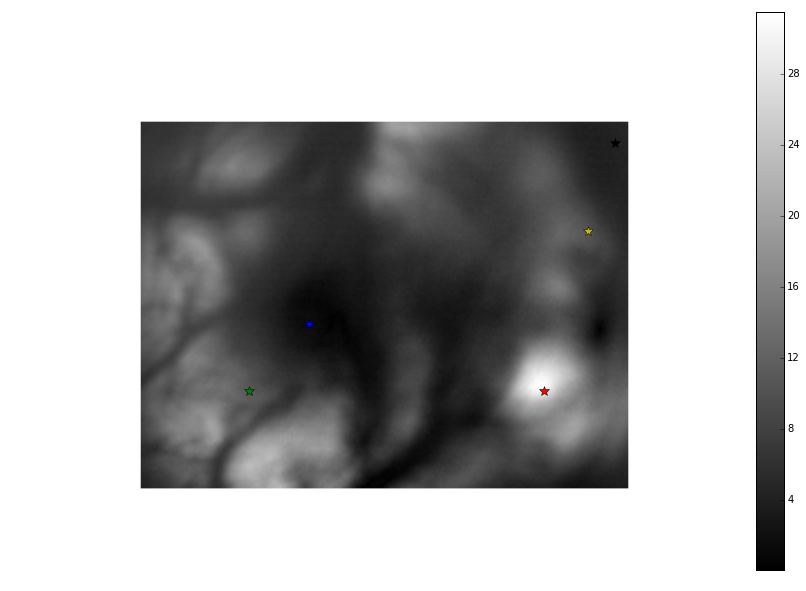

In [223]:
# MAKE A FIGURE WITH LCOS:

Ny = len(D[curr_key]['freqs'])/2.
fig = plt.figure(figsize=(20,10))

mag_map = D[curr_key]['mag_map']

plt.imshow(mag_map/Ny, cmap='gray')
plt.colorbar()

# CW_detrend_first: 
# good @ x=120, y=180
# medium @ x=120, y=48
# bad @ x=80, y=80

x=90#120
y=75##48 #180

xlocs = [120, 120, 90, 9, 48]
ylocs = [180, 48, 75, 212, 200]
colors = ['r', 'g', 'b', 'k', 'y']

for i in range(len(xlocs)):
    plt.plot(ylocs[i], xlocs[i], colors[i]+'*', markersize=10)
plt.axis('off')

if CW:
    imname = 'mag_locs_CW_pixel_x%i_y%i_%s_MAP_small' % (xlocs[-1], ylocs[-1], append)
else:
    imname = 'mag_locs_CCW_pixel_x%i_y%i_%s_MAP_small' % (xlocs[-1], ylocs[-1], append)
    
impath = os.path.join(outdir, imname+'.svg')
plt.savefig(impath, format='svg', dpi=1200)

impath = os.path.join(outdir, imname+'.jpg')
plt.savefig(impath, format='jpg')

print impath


(164, 218)
/media/nas/volume1/widefield/data/CE004/20160203/awake_circle_0013/structs/phase_locs_overlaymask_CCW_x48_y200_detrend_MAP+_small.jpg


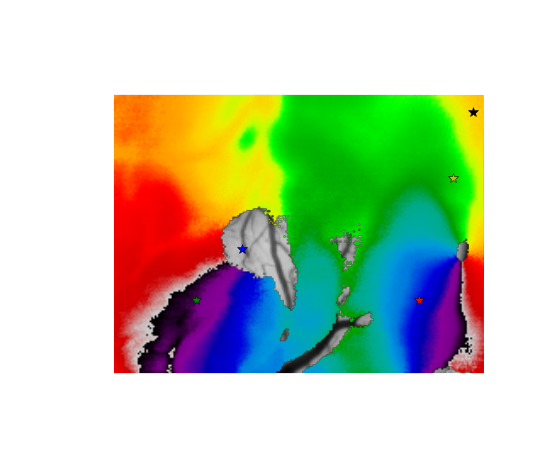

In [222]:
use_mean_intensity = 0 # set to 1 if want to threshold with mean intensity values instead of magnitude
use_log = 1
threshold = 0.30
Ny = len(D[curr_key]['freqs'])/2.
mag_map = D[curr_key]['mag_map']/Ny
phase_map = D[curr_key]['phase_map']

#-----------------------------------------------------------------
# Overlaid Phase-map, thresholded
#-----------------------------------------------------------------

fig = plt.figure(figsize=(20,10))

fig.add_subplot(1,2,1)
plt.imshow(surface,cmap=cm.Greys_r)
print surface.shape

if use_mean_intensity:
    mean_intensity = D[curr_key]['mean_intensity']
    [x, y] = np.where(mean_intensity >= threshold*mean_intensity.max())
    phase_mask = np.ones(mean_intensity.shape) * 100
    # phase_mask[x, y] = phase_map[x, y]
    phase_mask[x, y] = D[curr_key]['phase_map'][x, y]
    tit = 'Threshold, %.2f of mean intensity max' % (threshold)

else:
    if use_log:
        [x, y] = np.where(np.log(mag_map) >= threshold * np.log(mag_map.max()))
    else:
        [x, y] = np.where(mag_map >= threshold * mag_map.max())
    phase_mask = np.ones(mag_map.shape) * 100
    phase_mask[x, y] = phase_map[x, y]
    tit = 'Threshold, %.2f of log max magnitude' % (threshold)

[nullx, nully] = np.where(phase_mask == 100)
phase_mask[nullx, nully] = np.nan
phase_mask = np.ma.array(phase_mask)
plt.imshow(phase_mask, cmap='spectral', vmin=-1*math.pi, vmax=math.pi)
plt.axis('off')


# #-----------------------------------------------------------------
# # LEGEND
# #-----------------------------------------------------------------

# ax = fig.add_subplot(1,2,2, projection='polar')
# ax.set_theta_zero_location('W') # W puts 0 on RIGHT side...

# if CW:
#     ax._direction = 2*np.pi # object moves toward bottom first (CW)
# else:
#     ax._direction = -2*np.pi # objecct moves toward top first (CCW)

# norm = mpl.colors.Normalize(vmax=1*np.pi, vmin=-1*np.pi)
# #norm = mpl.colors.Normalize(vmax=2*np.pi, vmin=0)
# cb = mpl.colorbar.ColorbarBase(ax, cmap=cm.get_cmap('spectral'),
#                                 norm=norm, orientation='horizontal')
# # cb.ax.invert_xaxis()
# # cb.outline.set_visible(False)
# # ax.set_axis_off()
# ax.set_rlim([-1, 1])
# ax.axis('off')

# if CW:
#     imname = 'CW_phase_overlay_withkey_threshold%.2f' % threshold
# else:
#     imname = 'CCW_phase_overlay_withkey_threshold%.2f' % threshold
# impath = os.path.join(outdir, imname+'.eps')
# plt.savefig(impath, format='svg', dpi=1200)

# impath = os.path.join(outdir, imname+'.jpg')
# plt.savefig(impath, format='jpg')


# print impath

xlocs = [120, 120, 90, 9, 48]
ylocs = [180, 48, 75, 212, 200]
colors = ['r', 'g', 'b', 'k', 'y']
for i in range(len(xlocs)):
    plt.plot(ylocs[i], xlocs[i], colors[i]+'*', markersize=10)
plt.axis('off')

if CW:
    imname = 'phase_locs_overlaymask_CW_pixel_x%i_y%i_%s_MAP_small' % (xlocs[-1], ylocs[-1], append)
else:
    imname = 'phase_locs_overlaymask_CCW_x%i_y%i_%s_MAP+_small' % (xlocs[-1], ylocs[-1], append)
    
impath = os.path.join(outdir, imname+'.svg')
plt.savefig(impath, format='svg', dpi=1200)

impath = os.path.join(outdir, imname+'.jpg')
plt.savefig(impath, format='jpg')

print impath


[ 1327.  1302.  1305. ...,  1275.  1271.  1275.]
/media/nas/volume1/widefield/data/CE004/20160203/awake_circle_0013/structs/CCW_pixel_x120_y180_detrend_raw.jpg


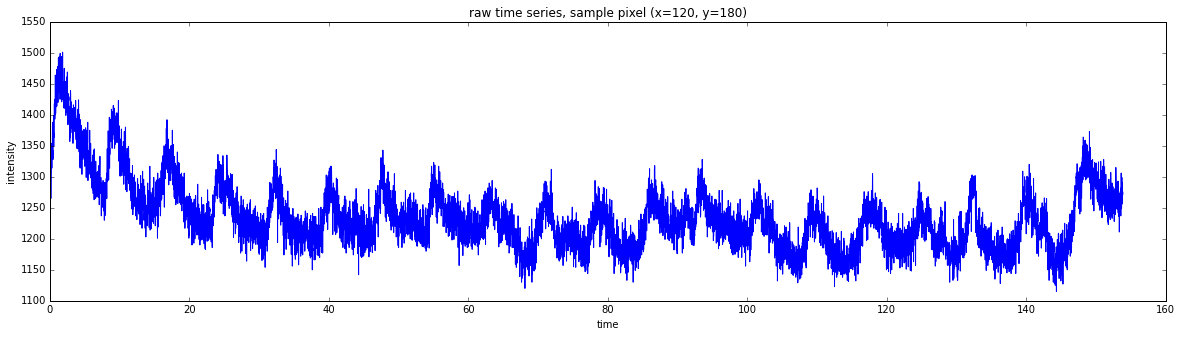

In [239]:
# Check out 1 pix:
fig = plt.figure(figsize=(20,5))

xlocs = [120, 120, 90, 9, 48]
ylocs = [180, 48, 75, 212, 200]
colors = ['r', 'g', 'b', 'k', 'y']

x = 120 #9 #48 #9 #90#120
y = 180 #212 #200 #209 #75 #48 #180

pix = S[x, y, :] #stack[x, y, :]

N = len(pix)
target_freq = 0.13
sampling_rate = 60.
dt = 1 / sampling_rate

time = 1 / sampling_rate * np.arange(N)
freqs = fft.fftfreq(len(pix), 1 / sampling_rate)

plt.plot(time, pix)

plt.xlabel('time')
plt.ylabel('intensity')
plt.title('raw time series, sample pixel (x=%i, y=%i)' % (x, y))

print pix


if CW:
    imname = 'CW_pixel_x%i_y%i_%s_raw' % (x, y, append)
else:
    imname = 'CCW_pixel_x%i_y%i_%s_raw' % (x, y, append)
    
impath = os.path.join(outdir, imname+'.svg')
plt.savefig(impath, format='svg', dpi=1200)

impath = os.path.join(outdir, imname+'.jpg')
plt.savefig(impath, format='jpg')

print impath

In [241]:
# Normalizing steps:
# del S
# stack = copy.deepcopy(S)

print "detrending..."

for x in range(sample.shape[0]):
    for y in range(sample.shape[1]):

        # THIS IS BASICALLY MOVING AVG WINDOW...
        pix = scipy.signal.detrend(stack[x, y, :], type='constant') # HP filter - over time...

        stack[x, y, :] = pix

# print "mean subtracting..."
# for i in range(stack.shape[2]):
#     stack[:,:,i] -= np.mean(stack[:,:,i].ravel()) 


detrending...


/media/nas/volume1/widefield/data/CE004/20160203/awake_circle_0013/structs/CCW_pixel_x120_y180_detrend_detrendedlast.jpg


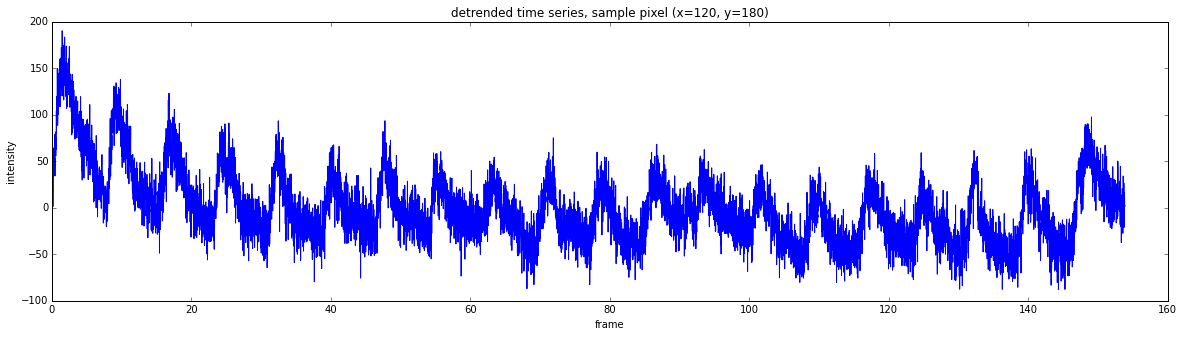

In [242]:
# # detrend first??
fig = plt.figure(figsize=(20,5))
x = 120 #9 #48 #9 #90#120 #60
y = 180 #212 #200 #209 #75#48#150 #130
p = stack[x, y, :]
# plt.plot(time[0:5000], p[0:5000])
plt.plot(time, p)

plt.xlabel('frame')
plt.ylabel('intensity')
plt.title('detrended time series, sample pixel (x=%i, y=%i)' % (x, y))


if CW:
    imname = 'CW_pixel_x%i_y%i_%s_detrendedlast' % (x, y, append)
else:
    imname = 'CCW_pixel_x%i_y%i_%s_detrendedlast' % (x, y, append)
    
impath = os.path.join(outdir, imname+'.svg')
plt.savefig(impath, format='svg', dpi=1200)

impath = os.path.join(outdir, imname+'.jpg')
plt.savefig(impath, format='jpg')

print impath

In [234]:

print "mean subtracting..."
for i in range(stack.shape[2]):
    stack[:,:,i] -= np.mean(stack[:,:,i].ravel()) 


mean subtracting...


[0, 461, 923, 1384, 1846, 2307, 2769, 3231, 3692, 4154, 4615, 5077, 5538, 6000, 6461, 6923, 7385, 7846, 8308, 8769, 9231]
[0, 461, 923, 1384, 1846, 2307, 2769, 3231, 3692, 4154, 4615, 5077, 5538, 6000, 6461, 6923, 7385, 7846, 8308, 8769]
/media/nas/volume1/widefield/data/CE004/20160203/awake_circle_0013/structs/CCW_pixel_x120_y180_detrend_detrendedfirst_meansub.jpg
PHASE:  -1.84524699455


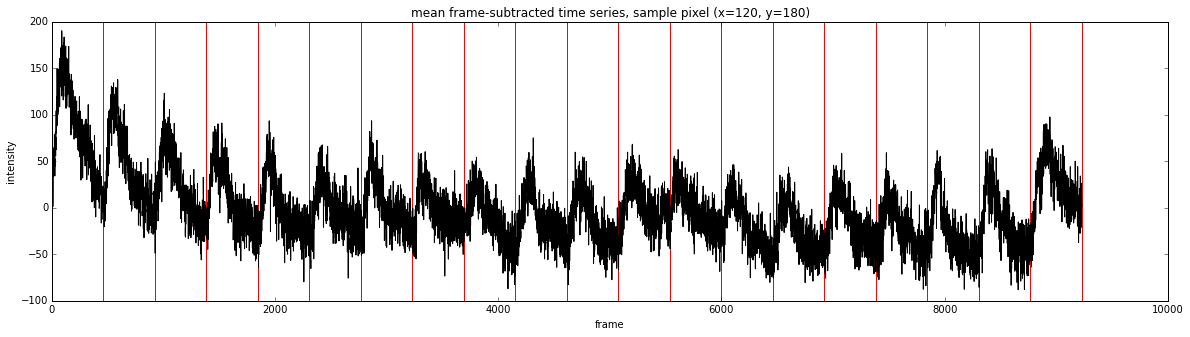

In [240]:
fig = plt.figure(figsize=(20,5))
x = 120 #9 #48 #9 #90#120
y = 180 #212 #200 #209 #75#48#180
p = stack[x, y, :]
# plt.plot(time, p)
# plt.plot(range(len(p)), p, 'k')

plt.xlabel('frame')
plt.ylabel('intensity')
plt.title('mean frame-subtracted time series, sample pixel (x=%i, y=%i)' % (x, y))

print strt_idxs
ncycles = 20

idxs = strt_idxs[0:ncycles]
print idxs
for i in strt_idxs:
	plt.axvline(i,color='r')
plt.plot(range(len(p)), p, 'k')



if CW: # i.e., this is PRE detrending, since detrending is last...
    imname = 'CW_pixel_x%i_y%i_%s_detrendedlast_meansub' % (x, y, append)
else:
    imname = 'CCW_pixel_x%i_y%i_%s_detrendedfirst_meansub' % (x, y, append)
    
impath = os.path.join(outdir, imname+'.svg')
plt.savefig(impath, format='svg', dpi=1200)

impath = os.path.join(outdir, imname+'.jpg')
plt.savefig(impath, format='jpg')

print impath

print "PHASE: ", phase_map[x, y]

In [87]:

print "detrending..."

for x in range(sample.shape[0]):
    for y in range(sample.shape[1]):

        # THIS IS BASICALLY MOVING AVG WINDOW...
        pix = scipy.signal.detrend(stack[x, y, :], type='constant') # HP filter - over time...

        stack[x, y, :] = pix


detrending...


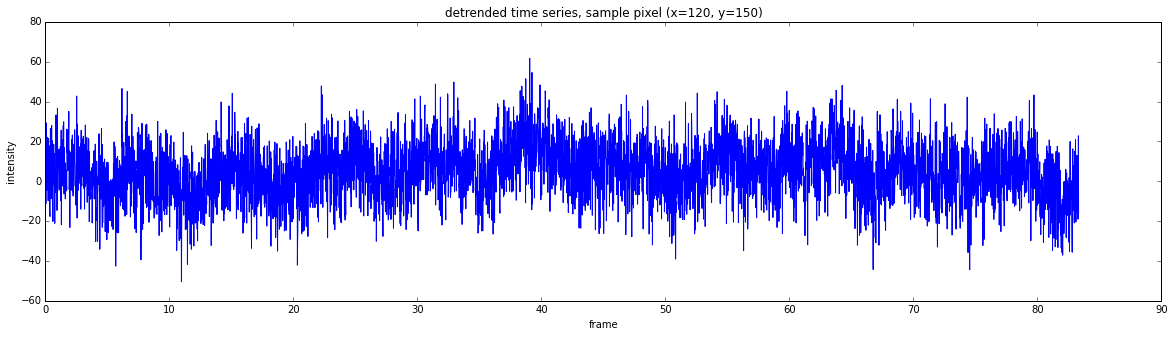

In [93]:
fig = plt.figure(figsize=(20,5))
x = 120 #60
y = 150 #130
p = stack[x, y, :]
plt.plot(time[0:5000], p[0:5000])
plt.xlabel('frame')
plt.ylabel('intensity')
plt.title('detrended time series, sample pixel (x=%i, y=%i)' % (x, y))


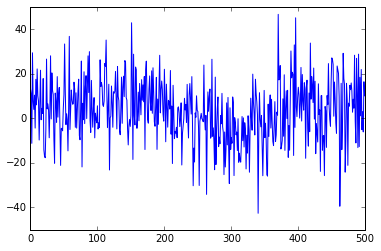

In [94]:
fig = plt.figure()
# fig.add_subplot(1,2,1)
# plt.plot(range(N), p)
# for i in strt_idxs:
# 	plt.axvline(i,color='r')
    
# fig.add_sublot(1,2,2)
plt.plot(range(N)[0:500], p[0:500])

[0, 461, 922, 1384, 1845, 2307, 2768, 3230, 3691, 4153, 4615, 5076, 5538, 5999, 6461, 6922, 7384, 7845, 8307, 8769, 9230]
[0, 461, 922, 1384, 1845, 2307, 2768, 3230, 3691, 4153, 4615, 5076, 5538, 5999, 6461, 6922, 7384, 7845, 8307, 8769]


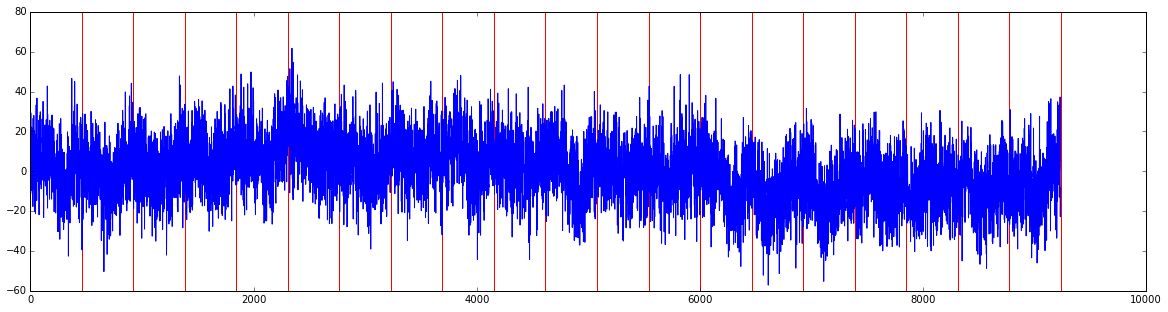

In [97]:
# Get histo of range of intensity values:

fig = plt.figure(figsize=(20,5))
print strt_idxs
ncycles = 20

idxs = strt_idxs[0:ncycles]
print idxs
for i in strt_idxs:
	plt.axvline(i,color='r')
plt.plot(range(N), p)
# intensities = [i for i in p if i>=0]
# np.histogram()

In [91]:
from plotly.offline import plot
import plotly.plotly as py

fig = plt.figure()
plt.plot(range(N), p)
for i in strt_idxs:
	plt.axvline(i,color='r')
    
py.iplot_mpl(fig, strip_style = True, filename='ipython/mpl_example')

In [17]:
print cw_key

Target_fft_stimulus_(1, 1)_detrendfirst.pkl


mag range:  0.140022597873 25.8451221725
phase range:  -3.14158911349 3.14134017383
HUE range:  5.63423956858e-07 0.999959816599
VAL range:  0.0 1.0
0.0
1.0


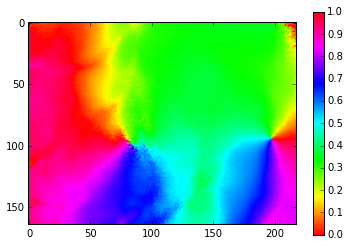

In [45]:

curr_key = cw_key

Ny = len(D[curr_key]['freqs'])/2.
fig = plt.figure()
mag_map = D[curr_key]['mag_map'] / Ny
phase_map = D[curr_key]['phase_map']

print "mag range: ", mag_map.min(), mag_map.max()
print "phase range: ", phase_map.min(), phase_map.max()

old_min = -math.pi #phase_map.min()
old_max = math.pi #phase_map.max()
new_min = 0
new_max = 1
normed_phase_map = np.zeros(phase_map.shape)
for x in range(phase_map.shape[0]):
    for y in range(phase_map.shape[1]):
        old_val = phase_map[x, y]
        normed_phase_map[x, y] = (((old_val - old_min) * (new_max - new_min)) / (old_max - old_min)) + new_min

old_min = mag_map.min()
old_max = mag_map.max()
new_min = 0
new_max = 1
normed_mag_map = np.zeros(mag_map.shape)
for x in range(mag_map.shape[0]):
    for y in range(mag_map.shape[1]):
        old_val = mag_map[x, y]
        normed_mag_map[x, y] = (((old_val - old_min) * (new_max - new_min)) / (old_max - old_min)) + new_min


hue = normed_phase_map
sat = np.ones(hue.shape)
val = normed_mag_map
print "HUE range: ", hue.min(), hue.max()
print "VAL range: ", val.min(), val.max()

HSV = np.ones(val.shape + (3,))
HSV[...,0] = hue
HSV[...,2] = sat * 1
HSV[...,1] = val

plt.imshow(normed_phase_map, cmap='hsv')
plt.colorbar()

print normed_mag_map.min()
print normed_mag_map.max()


In [52]:
import copy
cutoff = .3*max(normed_mag_map.ravel())
print "Cutoff at: ", cutoff
thresh_val = copy.deepcopy(val)
nons = []
for x in range(thresh_val.shape[0]):
    for y in range(thresh_val.shape[1]):

        if val[x, y] < cutoff:
            
            nons.append([x,y])
print len(nons)

Cutoff at:  0.3
20546


In [53]:
# HSV TO RGB:

import colorsys
convmap = np.empty(HSV.shape)

for i in range(HSV.shape[0]):
    for j in range(HSV.shape[1]):

            convmap[i, j, :] = colorsys.hsv_to_rgb(HSV[i,j,:][0], HSV[i,j,:][1], HSV[i,j,:][2])
print "HSV range: ", HSV.min(), HSV.max()
print convmap[i,j,:]
print convmap.min()

HSV range:  0.0 1.0
[ 1.          0.90277215  0.98982194]
0.0


(164, 218)


<matplotlib.colorbar.Colorbar instance at 0x7faf196a7488>

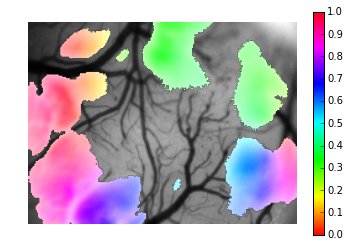

In [54]:
# MASK:

alpha_channel = np.ones(convmap[:,:,1].shape)
print alpha_channel.shape
for i in nons:
    alpha_channel[i[0], i[1]] = 0

composite = np.empty((alpha_channel.shape[0], alpha_channel.shape[1], 4))
composite[:,:,0:3] = convmap[:,:,:]

composite[:,:,3] = alpha_channel

plt.imshow(surface, 'gray')
plt.imshow(composite, 'hsv')
plt.axis('off')
plt.colorbar()